In [4]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [5]:
# https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_optotagging.html

In [6]:
output_dir = '/mnt/data/noah/allen/optotag_data'
# output_dir2=

In [7]:
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [8]:
sessions = cache.get_session_table()

sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64

NOTE: VIP, sst, and pvalb interneurons make up almost all of the GABAergic neocortical cells

In [9]:
pvalb_sessions = sessions[sessions.full_genotype.str.match('Pvalb')]
pvalb_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
746083955,2019-10-03T00:00:00Z,726170935,brain_observatory_1.1,98.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,582,2216,6,"[VPM, TH, LGd, CA3, CA2, CA1, VISal, nan, grey..."
760345702,2019-10-03T00:00:00Z,739783171,brain_observatory_1.1,103.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,501,1862,5,"[MB, TH, PP, PIL, DG, CA3, CA1, VISal, nan, gr..."
773418906,2019-10-03T00:00:00Z,757329624,brain_observatory_1.1,124.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546,2232,6,"[PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG..."
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."


In [10]:
session = cache.get_session_data(pvalb_sessions.index.values[-3])

In [11]:
session.optogenetic_stimulation_epochs.shape

(300, 6)

In [16]:
# help(session)

In [12]:
session.optogenetic_stimulation_epochs.condition.unique()

array(['a single square pulse', '2.5 ms pulses at 10 Hz',
       'half-period of a cosine wave'], dtype=object)

In [17]:
columns = ['stimulus_name', 'duration','level']
session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time']).shape


(12, 4)

In [28]:
sessions.index.values >= 789848216 #laser optotagging exps

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [29]:
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]

units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

time_resolution = 0.0005 # 0.5 ms bins

bin_edges = np.arange(-0.01, 0.025, time_resolution)

def optotagging_spike_counts(bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

da = optotagging_spike_counts(bin_edges, trials, units)

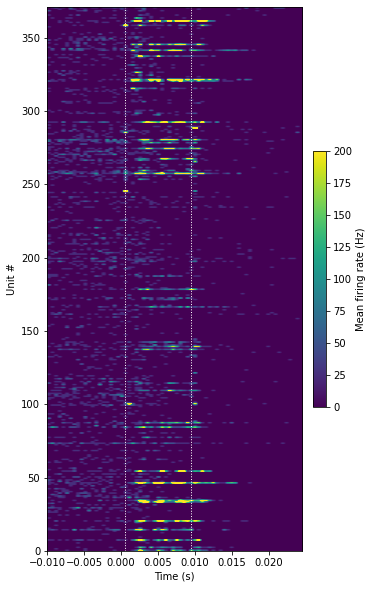

In [33]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)

In [34]:
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

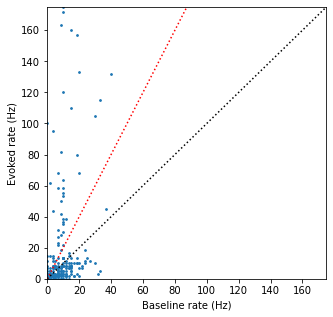

In [35]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 175
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

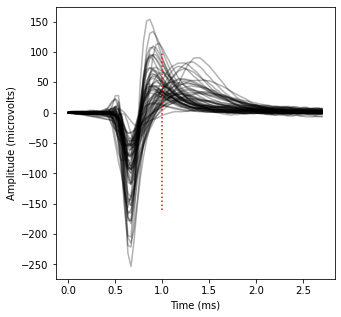

In [45]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values

plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':r')

In [46]:
vip_sessions = sessions[sessions.full_genotype.str.match('Vip')]

session = cache.get_session_data(vip_sessions.index.values[-1])

Downloading:   0%|          | 0.00/2.01G [00:00<?, ?B/s]

In [47]:
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]

units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

bin_edges = np.arange(-0.01, 0.025, 0.0005)

da = optotagging_spike_counts(bin_edges, trials, units)

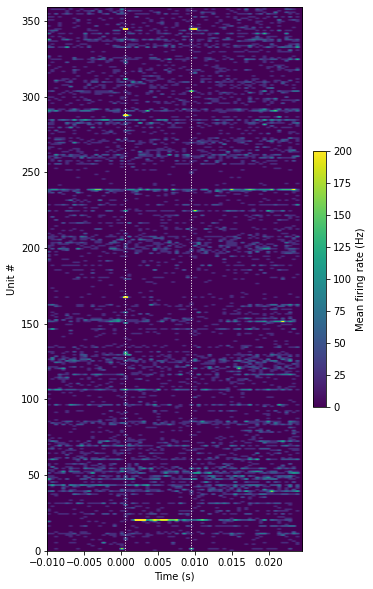

In [48]:
plot_optotagging_response(da)

In [50]:
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

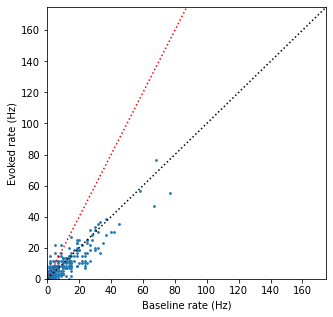

In [52]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 175
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

In [1]:
vip_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values

plt.figure(figsize=(5,5))

for unit_id in vip_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
# _ =plt.plot([1.0, 1.0],[-160, 100],':r')

NameError: name 'da' is not defined

In [55]:
#what data do I want?

#every unit tuned to the light (laser and led) stimulus, seperated by genotype
#individual spikes from single unit during opto and out of opto - compare these to ensure similar response
#control units? could still be the same type, just not expressing ChR
#location of each unit in brain
#ceed embedding for each spike. cluster, model to see if interneurons can be predicted
#ceed to find if individual cell types can be predicted